In [1]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,scipy,faker -g

CPython 3.5.3
IPython 5.1.0

pandas 0.19.2
numpy 1.11.3
scipy 0.19.0
faker n

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-79-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 92f197794a40b3992f64b8e246184a9e42aa7439


In [2]:
import pandas as pd

people_df = pd.read_csv('subscribers.csv')
action_df = pd.read_csv('actions.csv')
show_df = pd.read_csv('shows.csv')

In [3]:
import datetime

def calculate_age(bday):
    bday = datetime.datetime.strptime(bday,'%Y-%m-%d')

    today = datetime.date.today()
    return today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))

people_df['age'] = people_df['bday'].apply(calculate_age)

In [4]:
people_df.head()

,bday,name,p_id,sex,subscriber,age
0,1991-05-20,Sean Booth,0,M,1,26
1,1974-10-08,William Chandler,1,M,0,42
2,1981-11-30,Heather Nelson,2,F,0,35
3,1990-04-08,Nathan Jones,3,M,0,27
4,1993-04-05,Erica Adams,4,F,0,24


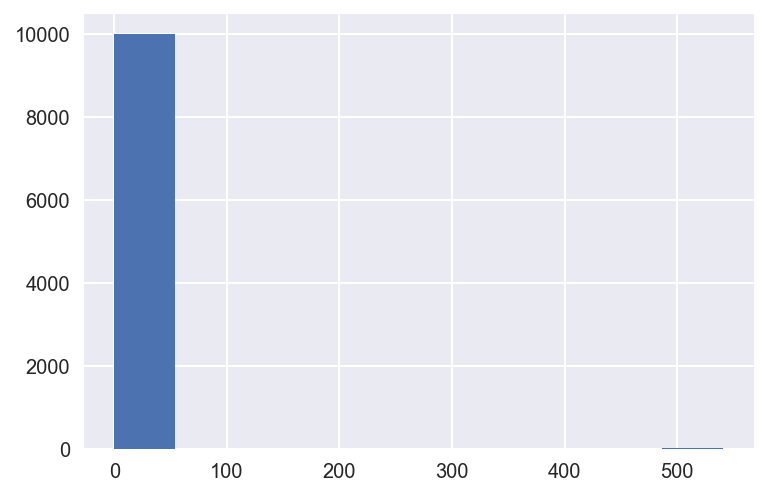

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

people_df.age.hist();

notice some really old people...

In [6]:
people_df = people_df.drop(['bday','name'],1)

In [7]:
all_df = pd.merge(action_df, people_df, on='p_id')
all_df = pd.merge(all_df, show_df, on='show_id')

In [8]:
action_df.shape

(100000, 2)

In [9]:
all_df.shape

(99959, 8)

Notice that not everyone made it through the join...

In [10]:
all_df = all_df[all_df.age < 150]

In [11]:
all_df.shape

(99834, 8)

In [12]:
all_df.head()

,p_id,show_id,sex,subscriber,age,description,genre,title
0,8314,6,F,1,29,a group of friends gets stuck in a suburban sh...,sci-fi,Cant Buy Time
1,8314,6,F,1,29,a group of friends gets stuck in a suburban sh...,sci-fi,Cant Buy Time
2,8314,6,F,1,29,a group of friends gets stuck in a suburban sh...,sci-fi,Cant Buy Time
3,8314,6,F,1,29,a group of friends gets stuck in a suburban sh...,sci-fi,Cant Buy Time
4,8314,6,F,1,29,a group of friends gets stuck in a suburban sh...,sci-fi,Cant Buy Time


In [13]:
shows = show_df.show_id.values

# grouped_df = all_df.groupby(['p_id','show_id'])['title'].count().unstack().reset_index().fillna(0)
# grouped_df['total'] = grouped_df[shows].sum(axis=1)
# grouped_df['total'] = grouped_df['total']/grouped_df['total'].max()
# grouped_df[shows] = grouped_df[shows].apply(lambda x: x/sum(x), axis=1)

grouped_df = all_df.groupby('p_id')['title'].count().reset_index()
grouped_df['title'] = grouped_df['title']/grouped_df.title.max()

In [14]:
all_df = all_df.drop(['show_id','description','title'],1)

In [15]:
all_df.head()

,p_id,sex,subscriber,age,genre
0,8314,F,1,29,sci-fi
1,8314,F,1,29,sci-fi
2,8314,F,1,29,sci-fi
3,8314,F,1,29,sci-fi
4,8314,F,1,29,sci-fi


In [16]:
all_df = pd.merge(people_df,grouped_df, on='p_id')

In [17]:
from sklearn.feature_extraction import DictVectorizer as DV

def oneHot_encode(df, col_list):
    oneHot_dict = df[col_list].to_dict(orient = 'records')
    vectorizer = DV(sparse = False)
    vec_oneHot = vectorizer.fit_transform(oneHot_dict)

    for i,columns in enumerate(vectorizer.feature_names_):
        df[columns] = vec_oneHot[:,i]
    
    for columns in col_list:
        df = df.drop(columns, 1)
    
    return df

all_df = oneHot_encode(all_df, ['sex'])

In [18]:
all_df.head()

,p_id,subscriber,age,title,sex=F,sex=M
0,0,1,26,0.264706,0.0,1.0
1,2,0,35,0.205882,1.0,0.0
2,3,0,27,0.294118,0.0,1.0
3,4,0,24,0.264706,1.0,0.0
4,5,0,46,0.235294,0.0,1.0


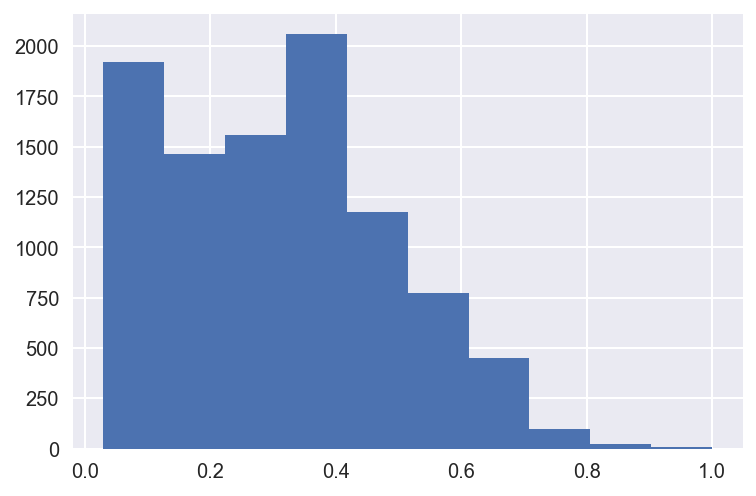

In [19]:
try:
    all_df.total.hist()
except:
    all_df.title.hist()

In [20]:
from sklearn.model_selection import train_test_split

all_df = all_df.drop('p_id',1)
y = all_df.pop('subscriber')
X = all_df.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
import numpy as np

# function for reporting cross validated hyper-parameter search
def report(results, n_top=3):
    """
    Function for printing various stats about models explored in cross-validated model search.
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Mean training score: {0:.3f}".format(
                  results['mean_train_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"base_estimator__max_depth": sp_randint(2,4),
              "base_estimator__max_features": sp_randint(1, X_train.shape[1]),
              "base_estimator__min_samples_leaf": sp_randint(2, 10),
              "n_estimators":sp_randint(10,100)}
clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'))

# run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=50)
random_search.fit(X_train,y_train)
report(random_search.cv_results_)

clf  = random_search.best_estimator_
joblib.dump(clf,'clf.pkl')

Model with rank: 1
Mean validation score: 0.711 (std: 0.009)
Mean training score: 0.722
Parameters: {'base_estimator__max_depth': 2, 'base_estimator__max_features': 3, 'n_estimators': 68, 'base_estimator__min_samples_leaf': 4}

Model with rank: 2
Mean validation score: 0.710 (std: 0.009)
Mean training score: 0.718
Parameters: {'base_estimator__max_depth': 2, 'base_estimator__max_features': 3, 'n_estimators': 29, 'base_estimator__min_samples_leaf': 7}

Model with rank: 3
Mean validation score: 0.709 (std: 0.012)
Mean training score: 0.719
Parameters: {'base_estimator__max_depth': 2, 'base_estimator__max_features': 3, 'n_estimators': 59, 'base_estimator__min_samples_leaf': 2}



['clf.pkl']

In [22]:
from sklearn import linear_model
lg = linear_model.LogisticRegression(class_weight='balanced')
lg.fit(X_train,y_train)
joblib.dump(lg, 'lg.pkl')

['lg.pkl']

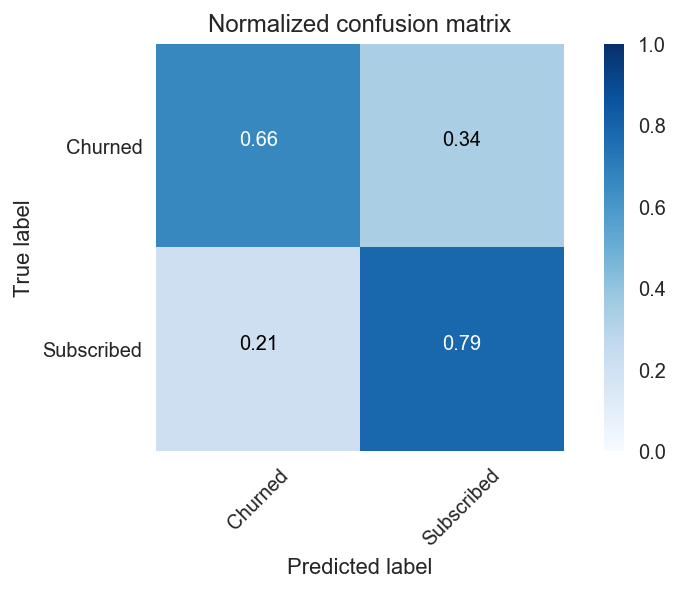

In [23]:
import itertools
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style('dark')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '%0.2f'%cm[i, j]
        plt.text(j, i, num,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churned','Subscribed'], normalize=True,\
                      title='Normalized confusion matrix')

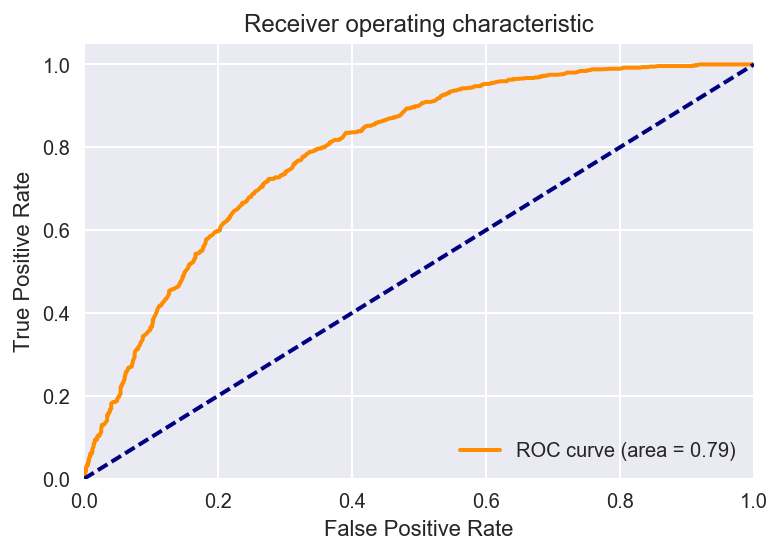

In [24]:
def create_ROC_plt(lg,X_test,y_test,lw=2):
    sns.set_style('darkgrid')
    try:
        y_score = lg.decision_function(X_test)
    except:
        y_score = lg.predict_proba(X_test)[:,1]
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',\
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

create_ROC_plt(clf,X_test,y_test)

In [25]:
np.mean(y_train)

0.4219016393442623

In [26]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, clf.predict(X_test)))

0.712113266911


In [27]:
print(accuracy_score(y_test, lg.predict(X_test)))

0.718930256948


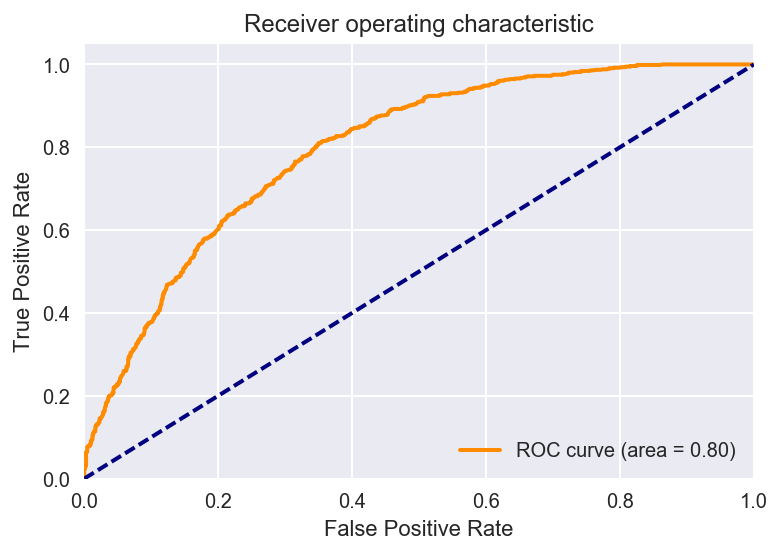

In [28]:
create_ROC_plt(lg,X_test,y_test)

In [29]:
print(np.mean(y_test))
print(np.mean(y_train))

0.4001048767697955
0.4219016393442623


In [30]:
all_df.head()

,age,title,sex=F,sex=M
0,26,0.264706,0.0,1.0
1,35,0.205882,1.0,0.0
2,27,0.294118,0.0,1.0
3,24,0.264706,1.0,0.0
4,46,0.235294,0.0,1.0


In [31]:
lg.coef_

array([[ -3.70e-03,   6.91e+00,  -7.02e-01,  -7.17e-01]])

In [32]:
clf.feature_importances_

array([ 0.39,  0.57,  0.04,  0.01])